<a href="https://colab.research.google.com/github/pannhapat/udacity_1001/blob/master/07_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#hyper parameters used 

lr_init = 0.001
lr_fine_tuned = 0.00001
batch_sz = 64
dropout_rate = 0.3
image_size = 224

In [0]:
import os
import random
import shutil

import numpy as np
import matplotlib.pyplot as plt

from keras.applications import MobileNet 
from keras.applications.mobilenet import preprocess_input

from keras import layers

from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.models import Model,load_model
from keras.optimizers import Adam
from keras import backend as K

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [0]:
def split_tr_tst(src_dir, tr_dir, tst_dir,tr_split = 0.8):
    items = os.listdir(src_dir)
    #print(items[1])
    random.shuffle(items)
    tst_cnt = round(len(items) * (1-tr_split))
    #print(tst_cnt)
    #print(items[1])
    test_items = items[:tst_cnt]
    train_items = items[tst_cnt:]
    if not(os.path.exists(tst_dir)):
                #print('creating ', dest_dir)
                os.makedirs(tst_dir)
    for item in test_items:
        item_path = os.path.join(src_dir,item)
        dest_path = os.path.join(tst_dir, item)
        shutil.copyfile(item_path,dest_path)
    if not(os.path.exists(tr_dir)):
                #print('creating ', dest_dir)
                os.makedirs(tr_dir)
    for item in train_items:
        item_path = os.path.join(src_dir,item)
        dest_path = os.path.join(tr_dir, item)
        shutil.copyfile(item_path,dest_path)

In [0]:
#all of these folders must exist

base_path = '/content/drive/My Drive/photos'
src = 'face_demo'
tr = 'train'
tst = 'test_faces'

dir_list = os.listdir(os.path.join(base_path,src))

#count the directories inside train dir for the number of category
#will be used to determine the number of classes of the model
num_categories = len(dir_list)



In [0]:
#only run this if there's still no data split between train and test set
for item in dir_list:
  src_dir = os.path.join(base_path,src,item)
  tr_dir = os.path.join(base_path,tr,item)
  tst_dir = os.path.join(base_path,tst,item)
  
  split_tr_tst(src_dir, tr_dir, tst_dir,tr_split = 0.8)


In [0]:
train_dir = os.path.join(base_path,tr)
test_dir = os.path.join(base_path,tst)

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    vertical_flip=False,
    preprocessing_function=preprocess_input)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(#rescale=1./255)
    preprocessing_function=preprocess_input)
train_generator = train_datagen.flow_from_directory(
        train_dir, # This is the source directory for training images
        target_size=(image_size, image_size),  
        batch_size=batch_sz,
        class_mode='categorical')

#get dictionary for the label name from the train_generator
class_dict = train_generator.class_indices.items()

# Flow validation images in batches of 20 using test_datagen generator
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(image_size, image_size),
        batch_size=batch_sz,
        class_mode='categorical')



Found 400 images belonging to 5 classes.
Found 100 images belonging to 5 classes.


(64, 224, 224, 3)


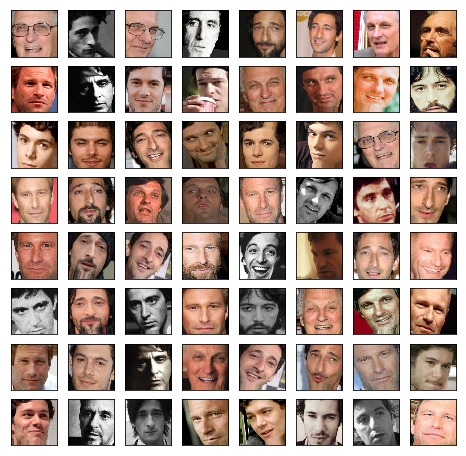

In [0]:
x_batch, y_batch = next(train_generator)
print(x_batch.shape)

fig = plt.figure(figsize=(8,8))

#show only the first 64 samples if batch size is over 64
for i in range(min(batch_sz,64)):
  fig.add_subplot(8, 8, 1 + i, xticks=[], yticks=[])

  #mobileNet preprocessing convert color range to [-1,1]
  #need to change to [0,1] to show color properly
  plt.imshow((x_batch[i]+1)/2)
plt.show()

(64, 224, 224, 3)


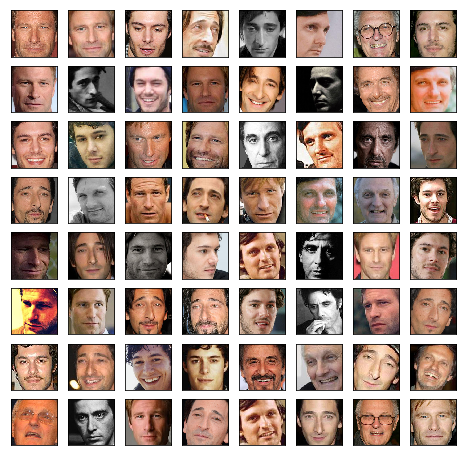

In [0]:
x_batch, y_batch = next(test_generator)

print(x_batch.shape)

fig = plt.figure(figsize=(8,8))

#show only the first 64 samples if batch size is over 64
for i in range(min(batch_sz,64)):
  fig.add_subplot(8, 8, 1 + i, xticks=[], yticks=[])
  #mobileNet preprocessing convert color range to [-1,1]
  #need to change to [0,1] to show color properly
  plt.imshow((x_batch[i]+1)/2)
plt.show()

In [0]:
pretrained_model =  MobileNet(input_shape=(image_size,image_size,3), include_top=False)

#freeze all layers
for layer in pretrained_model.layers:
  layer.trainable = False
  
pretrained_model.summary()

W0825 05:27:59.932121 140462242166656 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0825 05:27:59.970145 140462242166656 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0825 05:27:59.986627 140462242166656 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0825 05:28:00.019977 140462242166656 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0825 05:28:00.020801 1404622421

17227776/17225924 [==============================] - 1s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_b

In [0]:
def build_model(base_model, num_categories):

  #get the original output (before its actual top layer) from MobileNet
  org_output = base_model.layers[-1].output

  #the other form for building model in functional style
  #since we cant use the other method to modify pre-built models

  #x represent the output of the model we're modifying
  x = GlobalAveragePooling2D()(org_output)
  x = Dense(1024, activation='relu', name='custom_dense1024')(x)
  x = Dropout(dropout_rate)(x)
  x = Dense(num_categories, activation='softmax', name='output')(x)

  #create a new model from the existing pre-trained model stacking with our layers
  return Model(base_model.input, x)


In [0]:
model = build_model(pretrained_model, num_categories)
model.summary()

W0825 05:29:05.435532 140462242166656 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

In [0]:
model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(lr=lr_init), 
              metrics=['accuracy'])

W0825 05:29:19.430944 140462242166656 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [0]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=10,
      epochs=5,
      validation_data=test_generator,
      validation_steps=2,
      verbose=1)

W0825 05:29:31.359220 140462242166656 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/5
10/10 [==============================] - 177s 18s/step - loss: 2.6999 - acc: 0.3309 - val_loss: 1.8612 - val_acc: 0.2700
Epoch 2/5
10/10 [==============================] - 5s 549ms/step - loss: 1.1527 - acc: 0.5678 - val_loss: 1.4621 - val_acc: 0.3900
Epoch 3/5
10/10 [==============================] - 7s 670ms/step - loss: 0.6833 - acc: 0.7352 - val_loss: 1.7797 - val_acc: 0.3100
Epoch 4/5
10/10 [==============================] - 7s 659ms/step - loss: 0.4873 - acc: 0.8282 - val_loss: 2.2718 - val_acc: 0.2400
Epoch 5/5
10/10 [==============================] - 6s 605ms/step - loss: 0.4171 - acc: 0.8442 - val_loss: 1.5208 - val_acc: 0.3900


In [0]:
#save weights and rebuilt the model
#the reason we do this is because we need to re-compile the model
#if we want to change the learning rate
#and it causes out-of-memery error 
#if we do that too many times

model.save_weights('model_weights.hdf5')

#rebuild and re-load weights"
model = build_model(pretrained_model, num_categories)
model.load_weights('model_weights.hdf5')


#unfreeze the layers down to conv_pw_9

reached_conv_pw_9 = False
for layer in model.layers:
    if layer.name == 'conv_pw_9':
        reached_conv_pw_9 = True
    if reached_conv_pw_9:
        layer.trainable = True
        
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

In [0]:
model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(lr=lr_fine_tuned), 
              metrics=['accuracy'])

In [0]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=10,
      epochs=20,
      validation_data=test_generator,
      validation_steps=2,
      verbose=1)

Epoch 1/20
10/10 [==============================] - 9s 941ms/step - loss: 0.3330 - acc: 0.8838 - val_loss: 1.5332 - val_acc: 0.3800
Epoch 2/20
10/10 [==============================] - 6s 588ms/step - loss: 0.2816 - acc: 0.9120 - val_loss: 1.6428 - val_acc: 0.3400
Epoch 3/20
10/10 [==============================] - 7s 666ms/step - loss: 0.2478 - acc: 0.9386 - val_loss: 1.6933 - val_acc: 0.3100
Epoch 4/20
10/10 [==============================] - 6s 621ms/step - loss: 0.2690 - acc: 0.9099 - val_loss: 1.6476 - val_acc: 0.3400
Epoch 5/20
10/10 [==============================] - 7s 698ms/step - loss: 0.2032 - acc: 0.9411 - val_loss: 1.6406 - val_acc: 0.3700
Epoch 6/20
10/10 [==============================] - 6s 619ms/step - loss: 0.2235 - acc: 0.9332 - val_loss: 1.6580 - val_acc: 0.3700
Epoch 7/20
10/10 [==============================] - 7s 671ms/step - loss: 0.1987 - acc: 0.9454 - val_loss: 1.6377 - val_acc: 0.3600
Epoch 8/20
10/10 [==============================] - 7s 677ms/step - loss: 0.

In [0]:
img_path = '/content/drive/My Drive/photos/IMG_0690 (1).JPG'
img = image.load_img(img_path, target_size=(image_size,image_size))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x = preprocess_input(x)

print(model.predict(x))
print(class_dict)
